In [1]:
"""
This scripts runs post-processing steps for Eddy covariance data coming
in one file in the format of europe-fluxdata.eu. This format is very similar
to the ICOS format (the only known difference is the unit of pressure,
which is hPa in europe-fluxdata.eu and kPa in ICOS).

The script covers the following steps:
- spike / outlier detection with mean absolute deviation filter
  after Papale et al. (Biogeosci, 2006)
- ustar filtering after Papale et al. (Biogeosci, 2006)
- carbon flux partitioning with the nighttime method
  of Reichstein et al. (Global Change Biolo, 2005) and
  the daytime method of Lasslop et al. (Global Change Biolo, 2010)
- gap filling with marginal distribution sampling (MDS)
  of Reichstein et al. (Global Change Biolo, 2005)
- flux error estimates using MDS after Lasslop et al. (Biogeosci, 2008)

The script is controlled by a config file in Python's standard configparser
format. The config file includes all possible parameters of used routines.
Default parameter values follow the package REddyProc where appropriate. See
comments in config file for details.

The script currently flags on input all NaN values and given *undefined*
values. Variables should be set to *undefined* in case of other existing flags
before calling the script. Otherwise it should be easy to set the appropriate
flags in the pandas DataFrame dff for the flags after its creation around line
160.

The output file can either have all flagged variables set to *undefined*
and/or can include flag columns for each variable (see config file).

Note, ustar filtering needs at least one full year.

Examples
--------
python postproc_europe-fluxdata.py hesseflux_example.cfg

History
-------
Written, Matthias Cuntz, April 2020
"""

"""

27/09/2021

Integration of Footprint predictor model and satellite images from google earth engine 
to derive empirical remote sensing models and monthly and annual maps.

Written, Mario Alberto Fuentes Monjaraz, October 2021


"""

"""

5/09/2022

Getting code ready  to be used on VLABS

Pdrive: 11204971
/p/11204971-eshape/Interns/2_Mario_Fuentes/12-Deltares_GPP

"""

"""

3/01/2023

Final version code including analysis in Trognon and Finland

"""
"""
19/02/2024

Update of the code integrating new cloud removal fucntions and reading of data from GEE

Written, Mario Alberto Fuentes Monjaraz, October 2024

"""

'\n19/02/2024\n\nUpdate of the code integrating new cloud removal fucntions and reading of data from GEE\n\nWritten, Mario Alberto Fuentes Monjaraz, October 2024\n\n'

In [2]:
#Intallation of environment through jupyter notebooks
#The code requires Python 3.6 and the next packages
# !pip install numpy
# !pip install pandas
# !pip install hesseflux 
# !pip install pyproj
# !pip install earthengine-api
# !pip install statsmodels
# !pip install sklearn
# !pip install -U scikit-learn
# !pip install folium
# !pip install altair
# !pip install ipython

# Intallation of environment via conda 
# conda install -c anaconda python=3.6.13
# conda install -c anaconda numpy
# conda install -c anaconda pandas
# pip install hesseflux
# conda install -c conda-forge pyproj
# conda install -c conda-forge earthengine-api
# conda install -c anaconda statsmodels
# conda install -c anaconda scikit-learn
# conda install -c conda-forge folium
# conda install -c conda-forge altair
# conda install -c anaconda ipython

# Using an anaconda environment with python 3.11
# mamba install numpy pandas
# pip install hesseflux
# mamba install -c conda-forge pyproj
# mamba install conda-forge::earthengine-api
# mamba install -c anaconda statsmodels
# mamba install anaconda::scikit-learn
# mamba install conda-forge::folium
# mamba install conda-forge::altair
# mamba install -c anaconda ipython

In [3]:
#Import Python packages used in the code
#Original packages by Matthias Cuntz
import time as ptime
import sys
import configparser
import os.path
import numpy as np
import pandas as pd
import pyjams as pj
import hesseflux as hf

#Additional packages by Mario Alberto Fuentes Monjaraz 
import datetime as dt
from datetime import timedelta
import altair as alt
import math
from pyproj import Proj
import matplotlib.pyplot as plt
import ee
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy import stats
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import folium
from folium import plugins
from IPython.display import Image
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import time 
import FFP_Python.calc_footprint_FFP_climatology as ffpmodule
import urllib.request

#Activate to visualize the plots in the jupyternotebook
# plots %matplotlib inline

In [4]:
from GppTools import Gpp as gpp

In [5]:
#The workflow start here
if __name__ == '__main__':
    t1 = ptime.time()
    
    #0)    Inicialize code
    dgpp = gpp()

    #*************************************************************************************************************************************************************************
    #1a)   Read configuration file
    print('1a)  Opening configuration file')
    
    #1a.a) Read from command-line interpreter (It must include in the cosole "Deltares_GPP.py Configuration_file.cfg" located in the same adress)
    #if len(sys.argv) <= 1:
    #   raise IOError('Input configuration file must be given.')
    #configfile = sys.argv[1]                                                                              
                                                                                                       
    #1a.b) Read from directory path
    configfilepath = 'Configs/Configuration_file_Germany.cfg'                                                
    
    #1a.c) Read from gui window. Activate to manually select the congifuration file
    #configfile = hf.files_from_gui(initialdir='.', title='configuration file')                                                                       

    #1b)   Read file to retrieve file directories and model's marameters 
    print('1b)  Reading configuration file')

    dgpp.read_parameters(configfilepath)

1a)  Opening configuration file
1b)  Reading configuration file


In [6]:

    #*************************************************************************************************************************************************************************
    if not dgpp.calculated_gpp:
    #*************************************************************************************************************************************************************************
        #2)   Setting data frames
        print('2)   Formatting data frames')
        t01 = ptime.time()

        #---------------------------------------------------------------------------------------------------------------------------------------------------------------------
        #2.a)   Read eddy covariance files (eufluxfiles)
        nee_file = dgpp.read_nee_file(dgpp.inputdir,dgpp.eufluxfile,dgpp.skiprows, dgpp.timeformat, dgpp.sep)

        #---------------------------------------------------------------------------------------------------------------------------------------------------------------------
        #2.b)   Ensure constant 30-minute frequency in the datasets
        nee_file = dgpp.set_constant_timestep(nee_file)    

        #---------------------------------------------------------------------------------------------------------------------------------------------------------------------        
        #2.c)   Formatting the input file    
        nee_file, nee_file_flags = dgpp.format_nee_file(nee_file, dgpp.undef, dgpp.swthr, dgpp.remove_SW_IN)

        #---------------------------------------------------------------------------------------------------------------------------------------------------------------------
        t02   = ptime.time()  
        dgpp.time_counting(t01, t02, 'Computation setting data frames in ')

        #********************************************************************************************************************************************************************* 
        # 3)   Outlier detection
        if dgpp.outlier:
            print('3)   Spike detection \n')
            t11 = ptime.time()
            
            nee_file_flags, sflag = dgpp.outlier_detection(nee_file, nee_file_flags, dgpp.carbonflux, dgpp.isday, dgpp.undef, dgpp.nscan, dgpp.ntday, dgpp.nfill, dgpp.z, dgpp.deriv)

            t12   = ptime.time()                                                                           
            dgpp.time_counting(t11, t12, 'Computation setting data frames in ')

        #********************************************************************************************************************************************************************* 
        # 4) u* filtering (data for a full year)
        if  dgpp.ustar:                                                                                         
            print('4)   u* filtering \n')
            t21 = ptime.time()

            nee_file, nee_file_flags = dgpp.frictionvelocity_filter(nee_file, nee_file_flags, dgpp.carbonflux, dgpp.isday, dgpp.undef, dgpp.ustarmin, dgpp.nboot, dgpp.plateaucrit, dgpp.seasonout, dgpp.applyustarflag)

            t22   = ptime.time()
            dgpp.time_counting(t21, t22, 'Computation u* filtering detection in ')                                                                           

        #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        # 4)   u* filtering (data for partial year)
        if  dgpp.ustar_non_annual :                                                                             
            print('4)   u* filtering (less than 1-year data) \n')                                          
            t21 = ptime.time()    

            nee_file, nee_file_flags = dgpp.frictionvelocity_filter_nonannual(nee_file, nee_file_flags, dgpp.carbonflux, dgpp.undef, dgpp.ustarmin, sflag, dgpp.applyustarflag)                                                                         

            t22   = ptime.time() 
            dgpp.time_counting(t21, t22, 'Computation u* filtering detection in ')  

        #********************************************************************************************************************************************************************* 
        # 5)   Flux partitioning
        if dgpp.partition:
            print('5)   Flux partitioning \n')
            t31 = ptime.time()

            nee_file, nee_file_flags = dgpp.flux_partition(nee_file, nee_file_flags, dgpp.carbonflux, dgpp.isday, dgpp.undef, dgpp.nogppnight)

            t32   = ptime.time()
            dgpp.time_counting(t31, t32, 'Computation flux partitioning detection in ')  

        #********************************************************************************************************************************************************************* 
        # 6)   Gap-filling
        if dgpp.fill:        
            print('6)   Gap-filling \n')
            t41 = ptime.time()

            nee_file, nee_file_flags = dgpp.fill_gaps(nee_file, nee_file_flags, dgpp.carbonflux, dgpp.undef, dgpp.sw_dev, dgpp.ta_dev, dgpp.vpd_dev, dgpp.longgap)

            t42   = ptime.time()    
            dgpp.time_counting(t41, t42, 'Computation filling gaps detection in ')                              

        #********************************************************************************************************************************************************************* 
        # 7)   Error estimate
        if dgpp.fluxerr:
            print('7)   Flux error estimates \n')
            t51 = ptime.time()

            nee_file, nee_file_flags = dgpp.estimate_error(nee_file, nee_file_flags, dgpp.carbonflux, dgpp.undef, dgpp.sw_dev, dgpp.ta_dev, dgpp.vpd_dev, dgpp.longgap)

            t52   = ptime.time() 
            dgpp.time_counting(t51, t52, 'Computation flux error estimates in ')                                                                            

        #********************************************************************************************************************************************************************* 
        # 8)   Output
        print('8)   Outputfile \n')
        t61 = ptime.time()

        dgpp.write_gpp_files(nee_file, nee_file_flags, configfilepath, dgpp.ID, dgpp.outputdir, dgpp.outputfile, dgpp.outputname, dgpp.tkelvin, dgpp.vpdpa, dgpp.undef, dgpp.outundef, dgpp.outflagcols)

        t62   = ptime.time()
        dgpp.time_counting(t61, t62, 'Creating output file in ')  

        #*********************************************************************************************************************************************************************
        # Next elements are complement modules to compute Remote Sensing empirical models of GPP           
        #*********************************************************************************************************************************************************************
        # 9)   Daily estimations 
        if dgpp.daily_gpp:                                                                                       
            print('9)   Daily GPP \n')
            t71 = ptime.time()

            gpp_file = dgpp.estimate_daily_gpp(nee_file, dgpp.carbonflux, dgpp.carbonfluxlimit, dgpp.respirationlimit, dgpp.undef, dgpp.rolling_window_gpp, dgpp.rolling_center_gpp, dgpp.rolling_min_periods, dgpp.outputdir, dgpp.ID)

            t72   = ptime.time()
            dgpp.time_counting(t71, t72, ' Computed daily GPP in ')  

    #*************************************************************************************************************************************************************************
    if dgpp.calculated_gpp:
    #*************************************************************************************************************************************************************************
        #2)   Setting data fram
        print('2-9) Reading GPP file \n')
        t01 = ptime.time()

        nee_file, gpp_file = dgpp.read_daily_gpp_files(dgpp.outputdir, dgpp.outputfile, dgpp.ID, dgpp.outputname, dgpp.timeformat)
        
        t02   = ptime.time()   
        dgpp.time_counting(t01, t02, 'Reading file in ')                                                                              
            
    #*************************************************************************************************************************************************************************
    t2   = ptime.time() 
    dgpp.time_counting(t1, t2, 'Total time processing carbon data ')    

    #*********************************************************************************************************************************************************************     
    if dgpp.climatological_footprint:
        
        print('10)  Climatological footprint \n')
        t81 = ptime.time()

        years, fetch, footprint = dgpp.calculate_cf(nee_file, nee_file_flags, dgpp.carbonflux, dgpp.undef, dgpp.instrument_height_anenometer, dgpp.displacement_height, dgpp.roughness_lenght, dgpp.outputdir, dgpp.ID,dgpp.boundary_layer_height,dgpp.latitude,dgpp.longitude,dgpp.calculated_ffp,dgpp.domaint_var,dgpp.nxt_var,dgpp.rst_var,dgpp.projection_site)

        t82   = ptime.time()
        dgpp.time_counting(t81, t82, 'Computation climatological footprint in ')     

2)   Formatting data frames
      Read data:  /NEE/NEE_data_Germany_2019.txt


c:\Users\fuentesm\Marilu\Deltares\Projects\AGAME\GitHub\vlabs\sen2gpp\GppTools.py:256: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(filepath_or_buffer=infile, sep=sep, skiprows=skiprows, parse_dates=[0],


      Ensuring 30-minute frequncy
      Formating data


     Computation setting data frames in   0 [seconds]

3)   Spike detection 

      Using: ['NEE']

     Computation setting data frames in   0 [seconds]

4)   u* filtering (less than 1-year data) 

      Using: ['NEE', 'USTAR', 'TA']
      Using: ['NEE']

     Computation u* filtering detection in   0 [seconds]

5)   Flux partitioning 

      Using: ['NEE', 'SW_IN', 'TA', 'VPD']
      Nighttime partitioning


c:\Users\fuentesm\AppData\Local\anaconda3\envs\Deltares_GPP\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


      Falge method
      Daytime partitioning


c:\Users\fuentesm\AppData\Local\anaconda3\envs\Deltares_GPP\Lib\site-packages\scipy\optimize\_numdiff.py:598: RuntimeWarning: invalid value encountered in divide
  J_transposed[i] = df / dx
c:\Users\fuentesm\AppData\Local\anaconda3\envs\Deltares_GPP\Lib\site-packages\pyjams\functions\fit_functions.py:1027: RuntimeWarning: overflow encountered in exp
  return p[0] * np.exp(p[1] * (1. / (Tref - T0) - 1. / (T - T0)))
c:\Users\fuentesm\AppData\Local\anaconda3\envs\Deltares_GPP\Lib\site-packages\pyjams\functions\fit_functions.py:1027: RuntimeWarning: invalid value encountered in multiply
  return p[0] * np.exp(p[1] * (1. / (Tref - T0) - 1. / (T - T0)))



     Computation flux partitioning detection in   18 [seconds]

6)   Gap-filling 

      Using:['NEE', 'GPP_NEE_rei', 'RECO_NEE_rei', 'GPP_NEE_fal', 'RECO_NEE_fal', 'GPP_NEE_las', 'RECO_NEE_las', 'SW_IN', 'TA', 'VPD']

  Filling  NEE
  Filling  GPP_NEE_rei
  Filling  RECO_NEE_rei
  Filling  GPP_NEE_fal
  Filling  RECO_NEE_fal
  Filling  GPP_NEE_las
  Filling  RECO_NEE_las

     Computation filling gaps detection in   2 [seconds]

8)   Outputfile 

      Write output  Output/NEE_output/Germany_2019_v1_NEE_corrected_with_flags.xlsx
      Add flag columns for gap-filled variables.
      Write.

     Creating output file in   0 [seconds]

9)   Daily GPP 


      Computed daily GPP in   0 [seconds]


     Total time processing carbon data   23 [seconds]



11)   Vegetation indices time series 

The maximun cloud coverage in the image is: 30
The original size of the collection is 145
The filtered size of the collection is 37


The maximun cloud coverage in the area is: 100
The original size of the collection is 37
The filtered size of the collection is 37


       Exporting: Vegetation_indices.csv



     Computation vegetation indices in   11 [seconds]



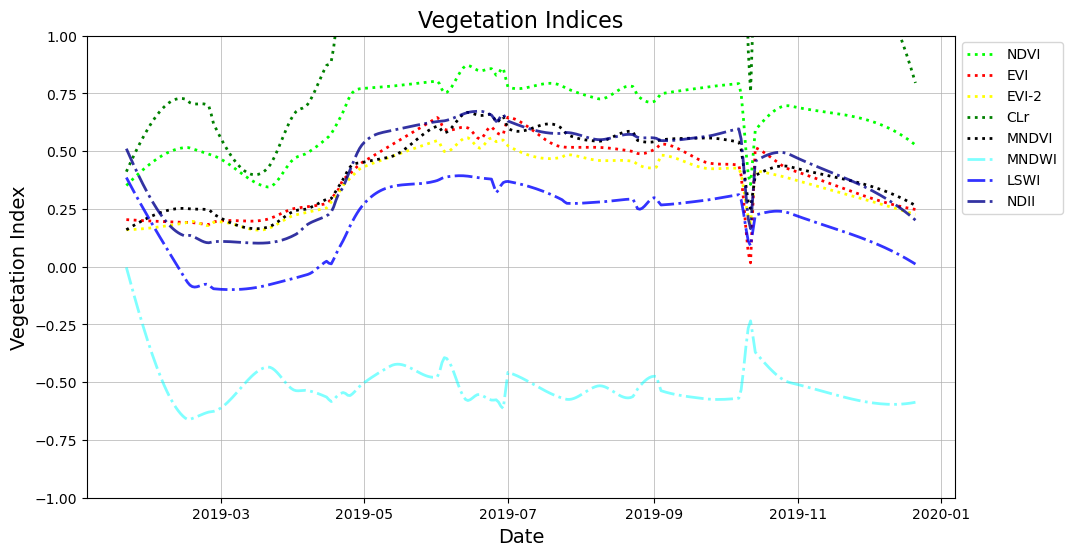

In [7]:
    #*********************************************************************************************************************************************************************
    if not dgpp.calculated_vi:
        #*********************************************************************************************************************************************************************     
        if dgpp.vegetation_indices:

            print('11)   Vegetation indices time series \n')
            t91 = ptime.time()

            ee.Authenticate() #For authentifications we require a Google Account registered in GEE (https://earthengine.google.com/)
            ee.Initialize()  

            # metadata parameters
            fetch = 100*(dgpp.instrument_height_anenometer - dgpp.displacement_height) #Fetch to height ratio https://www.mdpi.com/2073-4433/10/6/299
                                                                            #https://nicholas.duke.edu/people/faculty/katul/Matlab_footprint.html 

            # create aoi
            lon_lat         =  [dgpp.longitude, dgpp.latitude]
            point = ee.Geometry.Point(lon_lat)
            aoi  = point.buffer(fetch)

            # create aoi
            bbox_coordinates = aoi.bounds().coordinates().get(0)

            # Extract the coordinates
            min_x = ee.List(ee.List(bbox_coordinates).get(0)).get(0)
            min_y = ee.List(ee.List(bbox_coordinates).get(0)).get(1)
            max_x = ee.List(ee.List(bbox_coordinates).get(2)).get(0)
            max_y = ee.List(ee.List(bbox_coordinates).get(2)).get(1)

            # Create a geometry with the bounding box coordinates
            bbox = ee.Geometry.Rectangle([min_x, min_y, max_x, max_y])

            #df_VI_export = dgpp.calculate_VI(years, fetch, footprint, dgpp.rst_var,dgpp.longitude,dgpp.latitude,dgpp.max_cloud_coverage,dgpp.ndviMask, dgpp.mndviMask, dgpp.bands, dgpp.contourlines_frequency,dgpp.crs,dgpp.ID,dgpp.outputdir)
            df_VI_export = dgpp.calculate_VI_with_area(nee_file, nee_file_flags, dgpp.carbonflux, dgpp.undef, aoi, dgpp.longitude,dgpp.latitude,dgpp.max_cloud_coverage,dgpp.ndviMask, dgpp.mndviMask, dgpp.bands,dgpp.crs,dgpp.ID,dgpp.outputdir, dgpp.local_cloud_coverage)
        
            t92   = ptime.time()
            dgpp.time_counting(t91, t92, 'Computation vegetation indices in ')   

    #*********************************************************************************************************************************************************************
    if dgpp.calculated_vi:
        
        print('11)   Reading vegetation indices time series file \n')
        
        t91 = ptime.time()

        ee.Authenticate() #For authentifications we require a Google Account registered in GEE (https://earthengine.google.com/)
        ee.Initialize()  

        df_VI_export = dgpp.read_VI(dgpp.outputdir, dgpp.ID)
        
        t92   = ptime.time()
        dgpp.time_counting(t91, t92, 'Reading vegetation indices time series file in ')         

In [9]:
import geemap
import ee

Map = geemap.Map()
Map.centerObject(aoi, 15)
Map.addLayer(aoi, {'color': 'blue'}, 'aoi')
Map.addLayer(bbox, {'color': 'red'}, 'bbox')
Map

c:\Users\fuentesm\AppData\Local\anaconda3\envs\Deltares_GPP\Lib\site-packages\traitlets\__init__.py:28: DeprecationWarning: 
            Sentinel is not a public part of the traitlets API.
            It was published by mistake, and may be removed in the future.
            
  warn(
c:\Users\fuentesm\AppData\Local\anaconda3\envs\Deltares_GPP\Lib\site-packages\traittypes\traittypes.py:188: DeprecationWarning: metadata {'dtype': None} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  super(DataFrame, self).__init__(
c:\Users\fuentesm\AppData\Local\anaconda3\envs\Deltares_GPP\Lib\site-packages\geemap\conversion.py:22: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
c:\Users\fuentesm\AppData\Local\anaconda3\envs\Deltares_GPP\Lib\site-packages\pkg_resources\__init__.py:2871: DeprecationWarning: Deprecat

Map(center=[52.0865617101565, 11.222350077176555], controls=(WidgetControl(options=['position', 'transparent_b…

In [10]:
def calc_VI(df_bands):
    
    df_bands['MNDWI'] = (df_bands['B3']-df_bands['B11'])/(df_bands['B3']+df_bands['B11'])
    df_bands['EVI'] = 2.5*(df_bands['B8']-df_bands['B4'])/(df_bands['B8']+6*df_bands['B4']-7.5*df_bands['B2']+1)
    df_bands['EVI2'] = 2.5 * (df_bands['B8']-df_bands['B4'])/(df_bands['B8'] + 2.4*df_bands['B4'] + 1)
    df_bands['NDVI'] = (df_bands['B8']-df_bands['B4'])/(df_bands['B8']+df_bands['B4'])
    df_bands['CLr'] = (df_bands['B7']/df_bands['B5']) - 1
    
    df_bands['MNDVI'] = (df_bands['B7']-df_bands['B5'])/(df_bands['B7']+df_bands['B5'])
    df_bands['LSWI'] = (df_bands['B8']-df_bands['B11'])/(df_bands['B8']+df_bands['B11'])
    df_bands['NDII'] = (df_bands['B8']-df_bands['B12'])/(df_bands['B8']+df_bands['B12'])
    
    return df_bands

# Save plots of VI
def plot_timeseries_vi_multiple(df, bands):
    # subplots.
    fig, ax = plt.subplots(figsize=(14, 6)) #Indicates the size of the plot

    if 'NDVI' in bands:
        # add scatter plots //Adds the scatter points
        ax.plot(df['NDVI'],
                    c='#00FF00', alpha=1, label='NDVI', lw=2, linestyle = ':')
    if 'EVI' in bands:
        ax.plot(df['EVI'],
                    c='red', alpha=1, label='EVI', lw=2, linestyle = ':')
    if 'EVI2' in bands:
        ax.plot(df['EVI2'],
                    c='yellow', alpha=1, label='EVI-2', lw=2, linestyle = ':')
    if 'CLr' in bands:
        ax.plot(df['CLr'],
                    c='green', alpha=1, label='CLr', lw=2, linestyle = ':')
    if 'MNDVI' in bands:
        ax.plot(df['MNDVI'],
                    c='black', alpha=1, label='MNDVI', lw=2, linestyle = ':')
    if 'MNDWI' in bands:
        ax.plot(df['MNDWI'],
                    c='#00FFFF', alpha=0.5, label='MNDWI', lw=2, linestyle = '-.')
    if 'LSWI' in bands:
        ax.plot(df['LSWI'],
                    c='blue', alpha=0.8, label='LSWI', lw=2, linestyle = '-.')
    if 'NDII' in bands:
        ax.plot(df['NDII'],
                    c='#00008B', alpha=0.8, label='NDII', lw=2, linestyle = '-.') #marker="x", markersize=2)

    ax.set_title('Vegetation Indices', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Vegetation Index', fontsize=14)
    ax.set_ylim(-1, 1)
    ax.grid(lw=0.5)
    ax.legend(fontsize=14, loc='lower right')

    # shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, .8))
    #plt.savefig(outputdir + '/VI_output/' + ID + '_VI_timeseries.png', dpi=300, format='png', bbox_inches='tight',pad_inches=0.0001)
    # plt.savefig(outputdir + '/VI_output/' + ID + '_VI_timeseries.png', dpi=300)

    return plt #.show()


<module 'matplotlib.pyplot' from 'c:\\Users\\fuentesm\\AppData\\Local\\anaconda3\\envs\\Deltares_GPP\\Lib\\site-packages\\matplotlib\\pyplot.py'>

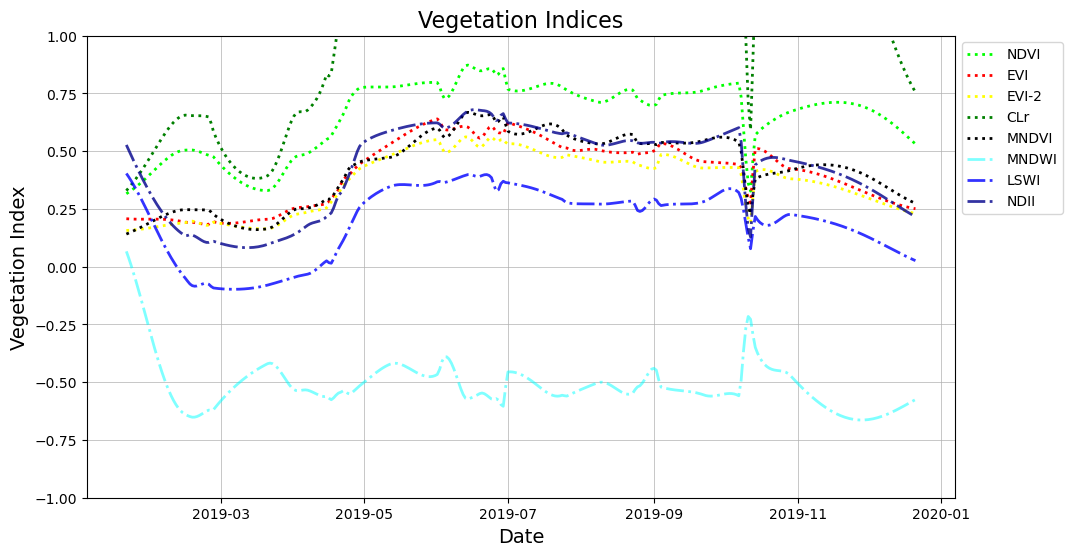

In [11]:
sp_VI = calc_VI(df_VI_export)
plot_timeseries_vi_multiple(sp_VI, dgpp.bands)